In [1]:
import matplotlib.pyplot as plot
import numpy as np
import math
from random import random
import scipy.stats as sp
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd

# Funciones para generar datos de prueba
Estas funciones sirven para generar datos artificiales siguiendo que simulan disparos neuronales siguiendo procesos de Poisson

In [23]:
def stimulatedSpikeTrain(firingRate, ms, stimRate, ini, fin):
    """
    stimulatedSpikeTrain Genera un tren aleatorio de disparos neuronales estimulado en una región de su longitud total a partir de un proceso de Poisson.
    El tren se representa como una lista de longitud ms cuyos elementos toman valor 1 (presencia de un disparo neuronal) o 0 (ausencia de un disparo neuronal).
    :param firingRate: Tasa de disparos por segundo en la región sin estimulación.
    :param ms: Longitud total del tren de disparos (representado en ms).
    :param stimRate: Tasa de disparos por segundo en la región de estimulación.
    :param ini: Inicio de la región de estimulación.
    :param fin: Final de la región de estimulación.
    :return: Lista de longitud ms cuyos elementos toman valor 1 (presencia de un disparo neuronal) o 0 (ausencia de un disparo neuronal).
    """
    spkT = []
    for i in range(ms):
        x = random()
        if i >= ini and i <= fin:
            if x < stimRate * 0.001:
                spkT.append(1)
            else:
                spkT.append(0)
        else:
            if x < firingRate * 0.001:
                spkT.append(1)
            else:
                spkT.append(0)
    return spkT

In [57]:
def generateExperimentData(nTrials, binSize, firingRate, ms, stimRate, ini, fin):
    """
    generateExperimentData Genera una lista de trenes de disparos neuronales con estimulación. 
    Además genera listas del número de disparos por bin (fragmento del tren) en regiones de estimulación y no estimulación.
    :param nTrials: Número de trenes de disparos neuronales que se generarán.
    :param binSize: Tamaño de los fragmentos en que se particionará el tren de disparos neuronales para medir el número de disparos.
    :param firingRate: Tasa de disparos por segundo en las regiónes sin estimulación .
    :param ms: Longitud de los trenes de disparos neuronales (representados en ms)
    :param stimRate: Tasa de disparos por segundo en las regiónes de estimulación.
    :param ini: Inicio de las regiónes de estimulación.
    :param fin: Final de las regiónes de estimulación.
    :return experimentData: Lista de trenes de disparos neuronales.
    :return bsHist: Lista que representa el histograma de números de disparos por bin en las regiones sin estimulación.
    :return stHist: Lista que representa el histograma de números de disparos por bin en las regiones de estimulación.
    """
    experimentData = []
    baselineSpk = []
    stimulusSpk = []

    for i in range(nTrials):
        spkT = stimulatedSpikeTrain(firingRate, ms, stimRate, ini, fin)
        experimentData.append(spkT)

        for j in range(int(len(spkT) / binSize)):
            cBin = spkT[j * binSize:(j + 1) * binSize]

            if j*binSize >= ini and j*binSize < fin:
                stimulusSpk.append(cBin.count(1))
            else:
                baselineSpk.append(cBin.count(1))
    
    bsHist = np.bincount(baselineSpk)
    stHist = np.bincount(stimulusSpk)

    return experimentData, bsHist, stHist

In [25]:
def plotExperimentData(expData, filename):
    """
    plotExperimentData Genera y guarda una imagen de un raster plot de los trenes de disparos neuronales que conforman los datos de un experimento.
    :param expData: Lista de trenes de disparos neuronales que conforman los datos de experimento.
    :param filename: Nombre del archivo de imagen que se guarda en el sistema.
    :return None: 
    """
    fig, ax = plot.subplots()
    for i in range(len(expData)):
        spkTimes = [i for i, x in enumerate(expData[i]) if x == 1]
        ax.vlines(spkTimes, i - 0.3, i + 0.3)
    ax.set_xlabel('Tiempo (ms)')
    ax.set_ylabel('Nº de prueba')
    ax.set_title('Tiempos de pulso')
    ax.set_xlim([0, len(expData[0])])
    #plot.axvline(x=1000, color="Red")
    #plot.axvline(x=1500, color="Red")
    plot.show()
    plot.savefig(filename, dpi=300)
    plot.clf()
    return 

# Ejemplo de uso de las funciones de generación de datos de prueba

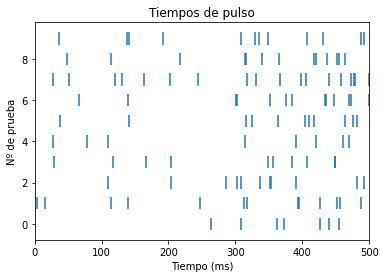

<Figure size 432x288 with 0 Axes>

In [26]:
expData, bsSpk, stSpk = generateExperimentData(10, 50, 15, 500, 35, 300, 500)
plotExperimentData(expData, "ejemplo.png")

# Funciones de procesamiento de ficheros de datos reales
Para analizar los datos reales partimos de dos tipos de ficheros. Uno contiene los tiempos en los que el sistema emite pulsos y el otro contiene los tiempos de inicio de las regiones de estimulación.
Las funciones que mostramos a continuación sirven para procesar los datos reales a partir de los ficheros descritos para posteriormente realizar el análisis.

In [28]:
def spkTrainFromFile(filepath):
    """
    spkTrainFromFile Genera un tren de disparos neuronales a partir de un fichero de pulsos del sistema.
    :param filepath: Ruta al archivo de impulsos deseado.
    :return: Tren de disparos neuronales generado a partir del fichero dado como entrada.
    """
    spkT = []
    f = open(filepath, "r")
    t = 0
    for line in f:
        while t < math.floor(float(line)):
            spkT.append(0)
            t += 1
        spkT.append(1)
        t += 1
    f.close()
    return spkT

In [22]:
def wordsFromSpikes(spkTrain, binsize):
    """
    wordsFromSpikes Genera una lista binaria a partir de un tren de disparos neuronales. El tren de disparos se divide 
    en fragmentos de tamaño binsize. Los elementos de la lista toman valor 1 si el fragmento del tren  de disparos al 
    que corresponde el elemento contiene 1 o más disparos. En caso contrario, los elementos de la lista toman valor 0.
    :param spkTrain: Tren de disparos neuronales.
    :param binsize: Tamaño de los fragmentos en los que se dividirá la señal.
    :return: Lista binaria generada. Cada elemento representa un fragmento del tren de disparos neuronales.
    """
    n = math.floor(len(spkTrain)/binsize)
    bins = []
    for i in range(n):
        if spkTrain[(i*binsize):(i*binsize+binsize)].count(1) > 0:
             bins.append(1)
        else:
             bins.append(0)
    return bins

In [ ]:
def generateImpulseFile(spkFile, wordBin, stimBin, delay, word, outputFile):
    """
    generateImpulseFile Genera un archivo de tiempos de inicio de regiones de estimulación realizando una detección de palabras 
    binarias en un tren de disparos neuronales generado a partir de un fichero de tiempos en los que el sistema emite pulsos.
    :param spkFile: Archivo de tiempos en los que el sistema emite pulsos.
    :param wordBin: Tamaño de binarización del tren de disparos neuronales.
    :param stimBin: Tamaño de la región de estimulación.
    :param delay: Retraso a la hora de definir el inicio de la región de estimulación.
    :param word: Lista binaria (elementos con valor 0 o 1) que representa la palabra binaria a detectar en el tren de disparos neuronales.
    :param outputFile: Ruta del fichero de tiempos de inicio de regiones de estimulación que genera la función.
    :return None:
    """
    spkC = spkTrainFromFile(spkFile)
    wordtC = wordsFromSpikes(spkC, wordBin)
    spkFile = open(spkFile, "r")
    spikes = []
    for line in spkFile:
        spikes.append(float(line))

    impulseTimes = []
    currentWord = []
    for i in range(len(wordtC)):
        currentWord.append(wordtC[i])
        if len(currentWord) < len(word):
            continue
        elif len(currentWord) > len(word):
            currentWord = currentWord[1:]

        if currentWord == word:
            cBin = spkC[(i*wordBin):((i+1)*wordBin)]
            spkIndex = cBin.index(1)
            impulseTimes.append((i*wordBin) + spkIndex + delay)
            if len(impulseTimes) > 1 and (impulseTimes[-1] - impulseTimes[-2]) < stimBin:
                impulseTimes = impulseTimes[:-1]

    #f = open("../data/1_sin_60/C1.dat.impulseTimes", "x")
    f = open(outputFile, "x")
    for el in impulseTimes:
        f.write(str(el)+"\n")
    f.close()
    return 

In [29]:
def spikesPerBin(spikes, impulses, binSize, binDelay):
    """
    spikesPerBin Genera un array de número de disparos en ventanas temporales pertenecientes a regiones de estimulación.
    :param spikes: Array que contiene tiempos disparos neuronales del sistema.
    :param impulses: Array que contiene tiempos de inicio de regiones de estimulación.
    :param binSize: Tamaño de las ventanas temporales en las que se medirán el número de disparos.
    :param binDelay: Retraso del inicio de las ventanas de medición de disparos respecto al incio de las regiones de estimulación.
    :return: Lista binaria generada. Cada elemento representa un fragmento del tren de disparos neuronales.
    """
    nspikes = []
    for impulse in impulses:
        n = 0
        for spike in spikes:
            if float(spike) >= float(impulse)+binDelay and float(spike) < float(impulse)+binSize+binDelay:
                n += 1
            elif float(spike) >= float(impulse)+binSize+binDelay:
                break
        nspikes.append(n)
        
    return np.array(nspikes)

In [261]:
def loadData(spikeFile, impulseFile, pmax, widthmax, step):
    """
    loadData Genera un array bidimensional de número de disparos en ventanas temporales variables a partir de ficheros de tiempos de disparo e inicio 
    de regiones de estimulación.
    :param spikeFile: Archivo de tiempos en los que el sistema emite pulsos.
    :param impulseFile: Archivo tiempos de inicio de regiones de estimulación.
    :param pmax: Retraso máximo del inicio de la ventanas de medición respecto al inicio de las regiones de estimulación. El mínimo es 0.
    :param widthmax: Tamaño máximo de las ventanas de medición de número de disparos. El mínimo es step.
    :param step: Incremento en el retraso de inicio de ventanas de medición y tamaños de ventana.
    :return: Array que contiene los datos de número de disparos procesados. Cada elemento es un array que contiene los valores de  retraso de inicio 
    de la ventana de medición y tamaño de ventana y otro array que representa un histograma de los valores de número de disparos detectados.
    """
    spk = np.loadtxt(spikeFile, delimiter=" ")
    imp = np.loadtxt(impulseFile, delimiter=" ")
    data = []
    for i in range(step, widthmax+1, step):
        for j in range(0, pmax+1, step):
            nspikes = spikesPerBin(spk, imp, i, j)
            hist = np.bincount(nspikes)
            data.append([i, j, hist])
    return data

In [75]:
def loadDataSplit(spkfile, impfile, pmax, widthmax, step):
    """
    loadData Genera dos arrays bidimensionales de número de disparos en ventanas temporales variables a partir de ficheros de tiempos de disparo e inicio 
    de regiones de estimulación. Se calculan los datos generados por el archivo entero y se divide aleatoriamente en dos muestras que se retornan.
    :param spikeFile: Archivo de tiempos en los que el sistema emite pulsos.
    :param impulseFile: Archivo tiempos de inicio de regiones de estimulación.
    :param pmax: Retraso máximo del inicio de la ventanas de medición respecto al inicio de las regiones de estimulación. El mínimo es 0.
    :param widthmax: Tamaño máximo de las ventanas de medición de número de disparos. El mínimo es step.
    :param step: Incremento en el retraso de inicio de ventanas de medición y tamaños de ventana.
    :return dataCA: Array que contiene la primera mitad de los datos de número de disparos procesados. Cada elemento es un array que contiene los valores de  retraso de inicio 
    de la ventana de medición y tamaño de ventana y otro array que representa un histograma de los valores de número de disparos detectados.
    :return dataCB: Array que contiene la segunda mitad los datos de número de disparos procesados. Cada elemento es un array que contiene los valores de  retraso de inicio 
    de la ventana de medición y tamaño de ventana y otro array que representa un histograma de los valores de número de disparos detectados.
    """
    dataCA = []
    dataCB = []
    spkC = np.loadtxt(spkfile, delimiter=" ")
    impC = np.loadtxt(impfile, delimiter=" ")
    for i in range(5, 151, 5):
        print("Vuelta " + str(i))
        for j in range(0, 51, 5):
            print("Subvuelta " + str(j))
            nspikesC = spikesPerBin(spkC, impC, i, j)
            nsCA, nsCB = train_test_split(nspikesC, test_size = 0.50)
            histA = np.bincount(nsCA)
            histB = np.bincount(nsCB)
            dataCA.append([i, j, histA])
            dataCB.append([i, j, histB])
    
    return dataCA, dataCB       

In [23]:
def saveProcessedData(data, filename):
    """
    saveProcessedData Genera y guarda un archivo con extensión .npy que almacena los datos procesados por las funciones loadData o loadDataSplit.
    :param data: Datos procesados por loadData o loadDataSplit.
    :param filename: Nombre del archivo que se generará y guardará.
    :return: Tren de disparos neuronales generado a partir del fichero dado como entrada.
    """
    with open(filename, 'wb') as f:
        np.save(f, np.array(data, dtype=object))
    return

In [212]:
def loadProcessedData(filename):
    """
    loadProcessedData Carga en un array un archivo con extensión .npy que almacena los datos procesados por las funciones loadData o loadDataSplit.
    :param filename: Nombre del archivo que se cargará.
    :return: Array contenido en el archivo filename.
    """
    with open('dataC1.npy', 'rb') as f:
        data = np.load(f, allow_pickle=True)
    return data

# Ejemplo de utilización de las funciones de procesamiento de datos

In [ ]:
#Procesa datos de número de disparos en ventanas de 5-150 ms de longitud y 0-50 de retraso respecto al inicio de la región de estimulación con un incremento de 5ms.
data = loadData("Desktop/Pececillos/data/1_sin_60/C.dat.spkTimes", "Desktop/Pececillos/data/1_sin_60/C11.dat.impulseTimes", 50, 150, 5)
#Guarda el archivo con los datos procesados.
saveProcessedData(data, "ejemplo.npy")
#Carga el archivo con los datos procesados.
data = loadProcessedData("ejemplo.npy")

# Funciones del método Bayesiano
Las funciones aquí descritas sirven para aplicar el método Bayesiano con diferentes observables a datos generados artificialmente o procesados por las funciones descritas previamente. 

In [31]:
def bayesianEstimatorD0(bsSpikes, stSpikes, umbral):
    """
    bayesianEstimatorD0 Calcula el valor del estimador bayesiano con el observable d=0 dados los valores de número de disparos
    en estimulación y no estimulación.
    :param bsSpikes: Lista que representa el histograma de número de disparos en ventanas correspondientes a regiones sin estimulación.
    :param stSpikes: Lista que representa el histograma de número de disparos en ventanas correspondientes a regiones con estimulación.
    :param umbral: Limitador para valores de los observables. Si el valor que se mide representa un porcentaje menor a umbral sobre el 
    total de valores, este no se tiene en cuenta.
    :return: valor del estimador bayesiano para el observable d=0.
    """
    baselineProbs = []
    stimulusProbs = []
    
    if stSpikes[0] != 0:
        if stSpikes[0]/np.sum(stSpikes) >= umbral:
            stimulusProbs.append(stSpikes[0] / np.sum(stSpikes))
            try:
                baselineProbs.append(bsSpikes[0] / np.sum(bsSpikes))
            except IndexError:
                baselineProbs.append(0)

    return  1 -  np.prod(baselineProbs)/np.prod(stimulusProbs)

In [47]:
def bayesianEstimatorD1(bsSpikes, stSpikes, umbral):
    """
    bayesianEstimatorD1 Calcula el valor del estimador bayesiano con el observable d=1 dados los valores de número de disparos
    en estimulación y no estimulación.
    :param bsSpikes: Lista que representa el histograma de número de disparos en ventanas correspondientes a regiones sin estimulación.
    :param stSpikes: Lista que representa el histograma de número de disparos en ventanas correspondientes a regiones con estimulación.
    :param umbral: Limitador para valores de los observables. Si el valor que se mide representa un porcentaje menor a umbral sobre el 
    total de valores, este no se tiene en cuenta.
    :return: valor del estimador bayesiano para el observable d=1.
    """
    baselineProbs = []
    stimulusProbs = []
    
    if stSpikes[1] != 0:
        if stSpikes[1]/np.sum(stSpikes) >= umbral:
            stimulusProbs.append(stSpikes[1] / np.sum(stSpikes))
            try:
                baselineProbs.append(bsSpikes[1] / np.sum(bsSpikes))
            except IndexError:
                baselineProbs.append(0)

    return  1 -  np.prod(baselineProbs)/np.prod(stimulusProbs)

In [48]:
def bayesianEstimatorD2(bsSpikes, stSpikes, umbral):
    """
    bayesianEstimatorD2 Calcula el valor del estimador bayesiano con el observable d=2 dados los valores de número de disparos
    en estimulación y no estimulación.
    :param bsSpikes: Lista que representa el histograma de número de disparos en ventanas correspondientes a regiones sin estimulación.
    :param stSpikes: Lista que representa el histograma de número de disparos en ventanas correspondientes a regiones con estimulación.
    :param umbral: Limitador para valores de los observables. Si el valor que se mide representa un porcentaje menor a umbral sobre el 
    total de valores, este no se tiene en cuenta.
    :return: valor del estimador bayesiano para el observable d=2.
    """
    baselineProbs = []
    stimulusProbs = []
    
    if stSpikes[2] != 0:
        if stSpikes[2]/np.sum(stSpikes) >= umbral:
            stimulusProbs.append(stSpikes[2] / np.sum(stSpikes))
            try:
                baselineProbs.append(bsSpikes[2] / np.sum(bsSpikes))
            except IndexError:
                baselineProbs.append(0)

    return  1 -  np.prod(baselineProbs)/np.prod(stimulusProbs)

In [49]:
def bayesianEstimatorD3(bsSpikes, stSpikes, umbral):
    """
    bayesianEstimatorD3 Calcula el valor del estimador bayesiano con el observable d=3 dados los valores de número de disparos
    en estimulación y no estimulación.
    :param bsSpikes: Lista que representa el histograma de número de disparos en ventanas correspondientes a regiones sin estimulación.
    :param stSpikes: Lista que representa el histograma de número de disparos en ventanas correspondientes a regiones con estimulación.
    :param umbral: Limitador para valores de los observables. Si el valor que se mide representa un porcentaje menor a umbral sobre el 
    total de valores, este no se tiene en cuenta.
    :return: valor del estimador bayesiano para el observable d=3.
    """
    baselineProbs = []
    stimulusProbs = []
    
    if stSpikes[3] != 0:
        if stSpikes[3]/np.sum(stSpikes) >= umbral:
            stimulusProbs.append(stSpikes[3] / np.sum(stSpikes))
            try:
                baselineProbs.append(bsSpikes[3] / np.sum(bsSpikes))
            except IndexError:
                baselineProbs.append(0)

    return  1 -  np.prod(baselineProbs)/np.prod(stimulusProbs)

In [50]:
def bayesianEstimatorD4(bsSpikes, stSpikes, umbral):
    """
    bayesianEstimatorD4 Calcula el valor del estimador bayesiano con el observable d=4 dados los valores de número de disparos
    en estimulación y no estimulación.
    :param bsSpikes: Lista que representa el histograma de número de disparos en ventanas correspondientes a regiones sin estimulación.
    :param stSpikes: Lista que representa el histograma de número de disparos en ventanas correspondientes a regiones con estimulación.
    :param umbral: Limitador para valores de los observables. Si el valor que se mide representa un porcentaje menor a umbral sobre el 
    total de valores, este no se tiene en cuenta.
    :return: valor del estimador bayesiano para el observable d=4.
    """
    baselineProbs = []
    stimulusProbs = []
    
    if stSpikes[4] != 0:
        if stSpikes[4]/np.sum(stSpikes) >= umbral:
            stimulusProbs.append(stSpikes[4] / np.sum(stSpikes))
            try:
                baselineProbs.append(bsSpikes[4] / np.sum(bsSpikes))
            except IndexError:
                baselineProbs.append(0)

    return  1 -  np.prod(baselineProbs)/np.prod(stimulusProbs)

In [51]:
def bayesianEstimatorTotal(bsSpikes, stSpikes, umbral):
    """
    bayesianEstimatorTotal Calcula el valor del estimador bayesiano con el observable total dados los valores de número de disparos
    en estimulación y no estimulación.
    :param bsSpikes: Lista que representa el histograma de número de disparos en ventanas correspondientes a regiones sin estimulación.
    :param stSpikes: Lista que representa el histograma de número de disparos en ventanas correspondientes a regiones con estimulación.
    :param umbral: Limitador para valores de los observables. Si el valor que se mide representa un porcentaje menor a umbral sobre el 
    total de valores, este no se tiene en cuenta.
    :return: valor del estimador bayesiano para el observable total.
    """
    baselineProbs = []
    stimulusProbs = []

    for i in range(len(stSpikes)):
        if stSpikes[i] != 0:
            if stSpikes[i]/np.sum(stSpikes) >= umbral:
                stimulusProbs.append(stSpikes[i] / np.sum(stSpikes))
                try:
                    baselineProbs.append(bsSpikes[i] / np.sum(bsSpikes))
                except IndexError:
                    baselineProbs.append(0)

    return  1 -  np.prod(baselineProbs)/np.prod(stimulusProbs)

In [38]:
def bootstrapData(original, nSamples, sampleSize):
    """
    bootstrapData Genera nSamples muestras de tamaño sampleSize a partir de original escogiendo aleatoriamente con remplazamiento.
    :param original: Datos originales que se van a remuestrear.
    :param nSamples: Número de muestras que se van a generar.
    :param sampleSize: Tamaño de las muestras que se van a generar.
    :return: Lista de muestras generadas.
    """
    data = []
    for i in range(nSamples):
        x = np.random.choice(original, size=sampleSize, replace=True)
        data.append(x)
    return data

In [69]:
def bayesianEstimatorBootstrap(bsSpikes, stSpikes, umbral, nSamples, bayesianObs):
    """
    bayesianEstimatorBootstrap Calcula la media y desviación típica de los valores del estimador bayesiano obtenidos dado un observable 
    y múltiples muestras obtenidas mediante bootstrap (remuestreo con remplazamiento) a partir de los datos originales dados como entrada.
    :param bsSpikes: Lista que representa el histograma de número de disparos en ventanas correspondientes a regiones sin estimulación.
    :param stSpikes: Lista que representa el histograma de número de disparos en ventanas correspondientes a regiones con estimulación.
    :param umbral: Limitador para valores de los observables. Si el valor que se mide representa un porcentaje menor a umbral sobre el 
    total de valores, este no se tiene en cuenta.
    :param nSamples: Número de muestras que se van a generar mediante bootstrap.
    :param bayesianObs: Función de estimador Bayesiano que se va a utilizar.
    :return: Media y desviación tipica de los valores obtenidos del estimador bayesiano.
    """
    cotas = []
    cotas.append(bayesianObs(bsSpikes, stSpikes, umbral))

    bsData = bootstrapData(np.repeat(np.arange(bsSpikes.size), bsSpikes), nSamples, len(bsSpikes))
    stData = bootstrapData(np.repeat(np.arange(stSpikes.size), stSpikes), nSamples, len(stSpikes))

    for i in range(nSamples):
        cotas.append(bayesianObs(bsData[i], stData[i], umbral))

    return np.mean(np.array(cotas)), np.std(np.array(cotas))

In [43]:
def plotPcolor(dataC, dataW, umbral, xlen, ylen, despx, despy, bayesianObs, title, filename):
    """
    plotPcolor Genera un gráfico en el que se muestran los valores del estimador bayesiano obtenidos para los datos dados como entrada.
    :param dataC: Datos de número de disparos en ventanas pertenecientes a regiones sin estimulación. Los datos son de la forma dada por 
    la salida de las funciones de procesamiento loadData o loadDataSplit.
    :param dataW: Datos de número de disparos en ventanas pertenecientes a regiones con estimulación. Los datos son de la forma dada por 
    la salida de las funciones de procesamiento loadData o loadDataSplit.
    :param umbral: Limitador para valores de los observables a la hora de calcular el estimador Bayesiano. Si el valor que se mide 
    representa un porcentaje menor a umbral sobre el total de valores, este no se tiene en cuenta.
    :param xlen: Retraso máximo del inicio de la ventanas de medición respecto al inicio de las regiones de estimulación. El mínimo es 0.
    :param ylen: Tamaño máximo de las ventanas de medición de número de disparos. El mínimo es despy.
    :param despx: Incremento en el retraso de inicio de las ventanas de medición respecto al inicio de las regiones de estimulación.
    :param despy: Incremento en el tamaño de las ventanas de medición de número de disparos.
    :param bayesianObs: Función de estimador Bayesiano que se va a utilizar. 
    :param title: Título del gráfico.
    :param filename: Archivo de imagen en el que se guardará el gráfico generado.
    :return: Valores del estimador bayesiano obtenidos para todas las ventanas de medición consideradas.
    """
    Z = []
    prev = dataW[0][0]
    aux = []
    for i in range(len(dataW)):
        if dataW[i][0] == prev:
            aux.append(bayesianObs(dataC[i][-1],dataW[i][-1], umbral))
        else:
            Z.append(aux)
            aux = []
            aux.append(bayesianObs(dataC[i][-1],dataW[i][-1], umbral))
        prev = dataW[i][0]

    Z.append(aux)
    Z = np.array(Z)
    Z[Z<0] = 0

    dx, dy = despx, despy
    y, x = np.mgrid[slice(despy, ylen + dy, dy),
                    slice(0, xlen + dx, dx)]

    levels = MaxNLocator(nbins=15).tick_values(Z.min(), Z.max())
    cmap = plot.get_cmap('RdYlBu')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    im = plot.pcolormesh(y, x, Z, cmap=cmap, norm=norm)
    plot.colorbar(im)
    plot.xlabel('Tamaño de ventana (T)')
    plot.ylabel('Desplazamiento de ventana (p)')
    plot.title(title)



    plot.tight_layout()
    plot.savefig(filename, dpi=300)
    plot.clf()
    
    return Z

In [207]:
def plotPcolorHist(dataC, dataW, umbral, xlen, ylen, despx, despy, bayesianObs, title, filename):
    """
    plotPcolor Genera un gráfico en el que se muestran los valores del estimador bayesiano obtenidos para los datos dados como entrada y un histograma de los valores positivos.
    :param dataC: Datos de número de disparos en ventanas pertenecientes a regiones sin estimulación. Los datos son de la forma dada por 
    la salida de las funciones de procesamiento loadData o loadDataSplit.
    :param dataW: Datos de número de disparos en ventanas pertenecientes a regiones con estimulación. Los datos son de la forma dada por 
    la salida de las funciones de procesamiento loadData o loadDataSplit.
    :param umbral: Limitador para valores de los observables a la hora de calcular el estimador Bayesiano. Si el valor que se mide 
    representa un porcentaje menor a umbral sobre el total de valores, este no se tiene en cuenta.
    :param xlen: Retraso máximo del inicio de la ventanas de medición respecto al inicio de las regiones de estimulación. El mínimo es 0.
    :param ylen: Tamaño máximo de las ventanas de medición de número de disparos. El mínimo es despy.
    :param despx: Incremento en el retraso de inicio de las ventanas de medición respecto al inicio de las regiones de estimulación.
    :param despy: Incremento en el tamaño de las ventanas de medición de número de disparos.
    :param bayesianObs: Función de estimador Bayesiano que se va a utilizar. 
    :param title: Título del gráfico.
    :param filename: Archivo de imagen en el que se guardará el gráfico generado.
    :return: Valores del estimador bayesiano obtenidos para todas las ventanas de medición consideradas.
    """
    Z = []
    prev = dataW[0][0]
    aux = []
    for i in range(len(dataW)):
        if dataW[i][0] == prev:
            aux.append(bayesianObs(dataC[i][-1],dataW[i][-1], umbral))
        else:
            Z.append(aux)
            aux = []
            aux.append(bayesianObs(dataC[i][-1],dataW[i][-1], umbral))
        prev = dataW[i][0]

    Z.append(aux)
    Z = np.array(Z)
    Z[Z<0] = 0

    dx, dy = despx, despy
    y, x = np.mgrid[slice(despy, ylen + dy, dy),
                    slice(0, xlen + dx, dx)]

    levels = MaxNLocator(nbins=15).tick_values(Z.min(), Z.max())
    cmap = plot.get_cmap('RdYlBu')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    
    fig, (ax0, ax1) = plot.subplots(1, 2)
    fig.set_figwidth(8)
    
    im = ax0.pcolormesh(y, x, Z, cmap=cmap, norm=norm)
    fig.colorbar(im, ax=ax0)
    ax0.set_title(title)
    ax0.set(xlabel='Tamaño de ventana (T)', ylabel='Desplazamiento de ventana (p)')

    Z = Z[Z != 0].flatten()
    sns.histplot(Z, element="bars", stat="probability", ax=ax1)
    ax1.set_title('Histograma de respuestas')
    ax1.set(xlabel='Valor del estimador', ylabel='Frecuencia')
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()
    #ax1.set(ylabel='')

    plot.tight_layout()
    plot.savefig(filename, dpi=300)
    plot.clf()
    
    return Z

# Ejemplo de utilización de las funciones del estimador Bayesiano

In [ ]:
#Genera datos para calcular el estimador bayesiano
expData, bsSpk, stSpk = generateExperimentData(50, 50, 30, 2000, 35, 1500, 1900)

#Valores del estimador bayesiano para diferentes observables
print(bayesianEstimatorD0(bsSpk, stSpk, 0))
print(bayesianEstimatorD1(bsSpk, stSpk, 0))
print(bayesianEstimatorD2(bsSpk, stSpk, 0))
print(bayesianEstimatorD3(bsSpk, stSpk, 0))
print(bayesianEstimatorD4(bsSpk, stSpk, 0))
print(bayesianEstimatorTotal(bsSpk, stSpk, 0))

#Valor de la media y desviación típica de 1000 estimadores bayesianos con el observable total calculados a partir de los datos originales 
print(bayesianEstimatorBootstrap(bsSpk, stSpk, 0, 1000, bayesianEstimatorTotal))